# Custom Multi-Qubit Delay Cross-Talk Error Simulator Backend

This notebook adds a customized `DelayAerSimulator` backend that extends the `AerSimulator` to support simulation of parameterized delay noise in scheduled circuits.

## Motivation

Recently, the ability to schedule circuits was added to qiskit to reason about duration and timing of instructions in circuits.  This process adds delay gates into a circuit when a qubit is idle.  For accurate noisy simulations, qubits should have cross-talk noise when multiple connected qubits are in a delay.

The current way noise is implemented adds noise based purely on each gate without consideration of other qubits/delays.  This notebook provides a way to add cross-talk errors that depend on duration to the noise model.  These errors are the most prevalent type of error because they show up with Delays, which are a prolific part of every circuit.

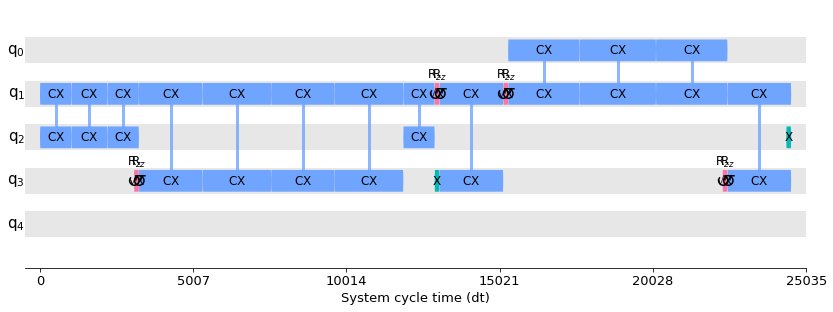

In [1]:
from qiskit.visualization.timeline import draw
from qiskit import QuantumCircuit, transpile
from qiskit.test.mock import FakeVigo

# Simulator backend
_delay_ex_backend = FakeVigo()

# Make a cirucit
_qc = QuantumCircuit(4)
_qc.h(0)
_qc.cx(0, 1)
_qc.x(1)
_qc.cx(0, 2)
_qc.x(2)
_qc.cz(1, 0)
_qc.h(1)
_qc.cx(1, 3)

# Schedule
_sched_circ = transpile(_qc, _delay_ex_backend, scheduling_method='alap')
draw(_sched_circ)

In [2]:
_sched_circ.draw(fold=-1)

┌──────────────────┐                                                                                                                                                                         ┌───┐     ┌─────────────────┐
      q_3 -> 0 ┤ DELAY(15296[dt]) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────┤ X ├──■──┤ DELAY(2080[dt]) ├
               └──────────────────┘   ┌───┐                            ┌───┐     ┌───┐                            ┌─────────┐     ┌────┐┌─────────┐┌───┐    ┌─────────┐       ┌────┐  ┌─────────┐   ┌─┴─┐   └─┬─┘┌─┴─┐└──────┬───┬──────┘
      q_2 -> 1 ─────────■─────────────┤ X ├─────■──────────────────────┤ X ├──■──┤ X ├──■───────────■─────────────┤ RZ(π/2) ├─────┤ √X ├┤ RZ(π/2) ├┤ X ├────┤ RZ(π/2) ├───────┤ √X ├──┤ RZ(π/2) ├───┤ X ├─────■──┤ X ├───────┤ X ├───────
                      ┌─┴─┐           └─┬─┘   ┌─┴─┐ ┌─────────────────┐└─┬─┘  │  └─┬─┘  │         ┌─┴─┐       ┌───┴─────────┴────┐├───┬┘└─────────┘└─┬─┘    └─────────┘       └────┘  └─────────┘   └───┘        └───┘       └─┬─┘       
      q_1 -> 2 ───────┤ X ├─────────────■─────┤ X ├─┤ DELAY(8640[dt]) ├──┼────┼────┼────┼─────────┤ X ├───────┤ DELAY(11488[dt]) ├┤ X ├──────────────┼─────────────────────────────────────────────────────────────────────────┼─────────
               ┌──────┴───┴──────┐ ┌─────────┐├───┴┐└───┬─────────┬───┘  │  ┌─┴─┐  │  ┌─┴─┐┌──────┴───┴──────┐└──────┬───┬───────┘└───┘              │  ┌─────────────────┐┌─────────┐   ┌────┐  ┌─────────┐                   │         
      q_0 -> 3 ┤ DELAY(3072[dt]) ├─┤ RZ(π/2) ├┤ √X ├────┤ RZ(π/2) ├──────■──┤ X ├──■──┤ X ├┤ DELAY(1024[dt]) ├───────┤ X ├───────────────────────────■──┤ DELAY(7168[dt]) ├┤ RZ(π/2) ├───┤ √X ├──┤ RZ(π/2) ├───────────────────■─────────
               ├─────────────────┴┐└─────────┘└────┘    └─────────┘         └───┘     └───┘└─────────────────┘       └───┘                              └─────────────────┘└─────────┘   └────┘  └─────────┘                             
ancilla_0 -> 4 ┤ DELAY(24544[dt]) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               └──────────────────┘

## Implementation

The from_backend function allows this custom simulator to run an additional pass after the circuit has been transpiled.  During this pass, analysis data regarding the delays and duration of the delays is added to the circuit metadata.  This pass then adds a custom label to each delay gate to specify the duration of the delay.  After the pass finishes running, a post processing step is applied which takes each custom label and adds a thermal relaxation error to the noise model in the given simulator based on the length of the delay given in the circuit metadata.

todo:: expand^
via transpilation pass that does it via noise model

## Simulation

To simulate parameterized delay errors with this backend:

1. The backend must contain a properties that includes T1, T2, and gate durations for all gates in the basis gates.
1. The simulator `cross_talk_noise` option must be set to `True` (this defaults to True if simulator is constructed using `DelayAerSimulator.from_backend`)
2. The input circuits must contain delay instructions to add errors to (eg be scheduled using `transpile(circuits, backend, scheduling_method=val)`)


### Example:
```python
# Device noise simulator
simulator = DelayAerSimulator.from_backend(real_backend)

# Schedule circuits
scheduled_circuits = transpile(circuits, simulator, scheduling_method='alap')

# Run
result = simulator.run(scheduled_circuits).result()
```

In [3]:
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.backends.aerbackend import AerBackend
from qiskit.providers.aer.noise import NoiseModel, thermal_relaxation_error
from qiskit.transpiler import PassManager
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.dagcircuit import DAGCircuit
from qiskit.circuit import Delay
from qiskit.circuit.library import RZZGate, RZGate, CXGate
from qiskit import QuantumCircuit, QuantumRegister
import copy

class DelayAerSimulator(AerSimulator):

    #Cross talk delay pass
    class CrossTalkDelayReplace(TransformationPass):
        """Adds cross-talk delay error information to circuit metadata for noise model post processing"""

        def __init__(self, coupling_map):
            """CrossTalk initializer
            Args:
                coupling_map (list(list(int)) or None): Coupling map for provided backend.  If None, pass will
                      not run
            """
            super().__init__()
            self.coupling_map = coupling_map

        def initQubitMapping(self, dag):
            """Initialize the qubit mapping to index and provide convenient
                variables for current time, if the previous op was a delay, and
                what the previous op's duration was.  For use when iterating over
                the DAG.

            Args:
                dag (DAGCircuit): the DAG to be optimized

            Returns:
                mapping of qubit to index and other loop variables (described above)
            """
            #if there's a coupling map when transpiled, it flattens all other registers
            #####dag.qubits <- the order of this list is the order in the coupling map
            return {qubit: {"idx": i,
                            "currTime": 0,
                            "prevOpDelay": False,
                            "prevOpDuration": 0,
                           }
                    for i, qubit in enumerate(dag.qubits)}

        def splitDelay(self, startTime, duration, pivotTimes):
            """Splits a delay based on 'pivotTimes' array.

            Args:
                startTime  (int)      : delay start time
                duration   (int)      : delay duration
                pivotTimes (List(int)): list of times to split on

            Returns:
                dag (DAGCircuit): the list of new delays to replace the old one
            """
            endTime = startTime + duration

            #split and do stuff based on start and end times
            newCircuit = DAGCircuit()
            reg = QuantumRegister(1)
            newCircuit.add_qreg(reg)

            #need to split at every array element of pivotTimes in between startTime and endTime
            lastTime = startTime
            for time in pivotTimes:
                #need to not add delay of length 0 (startTime <)
                # but need to include the last delay until the end time (<= endTime)
                if startTime < time <= endTime:
                    #split
                    newCircuit.apply_operation_back(Delay(duration=time-lastTime), [reg[0]], [])
                    lastTime = time

            return newCircuit

        def getDelayPivotTimes(self, dag):
            """Gets all delay start and end times for the given circuit

            Args:
                dag (DAGCircuit): the dag to extract start and end times from

            Returns:
                List(int): list of all delay start and end times
            """
            ##reset qubit_mapping params
            qubit_mapping = self.initQubitMapping(dag)
            startTimes = []
            endTimes = []

            #iterate and extract times
            ##this relies on the assumption that each node returned by topological_op_nodes is
            ## in natural time order per qubit (not overall, only within each qubit)
            for node in dag.topological_op_nodes():
                op = node.op
                qubits = node.qargs
                duration = op.duration

                for qubit in qubits:
                    #check op type
                    if isinstance(op, Delay):
                        # if prev command wasn't a delay, add new delay start time
                        if not qubit_mapping[qubit]["prevOpDelay"]:
                            qubit_mapping[qubit]["prevOpDelay"] = True
                            startTimes.append(qubit_mapping[qubit]["currTime"])

                    else:
                        #if prev command was a delay, this signifies the end of a delay
                        if qubit_mapping[qubit]["prevOpDelay"]:
                            #append end time to list
                            endTimes.append(qubit_mapping[qubit]["currTime"])
                        qubit_mapping[qubit]["prevOpDelay"] = False


                    #get duration and add to offset
                    qubit_mapping[qubit]["currTime"] += duration
                    qubit_mapping[qubit]["prevOpDuration"] = duration

            #handle if it's the last delay/op for the qubit
            for qubit, data in qubit_mapping.items():
                if data["prevOpDelay"]:
                    #add end time to list
                    endTimes.append(data["currTime"])

            #any time a delay starts or ends, that is a significant event
            return sorted(set(startTimes + endTimes))

        def createNewCircuitWithDelays(self, dag, pivotTimes):
            """Creates a new circuit with all delays split on every "pivot" time

            Args:
                dag (DAGCircuit)      : the dag to split delay times on
                pivotTimes (list(int)): list of start and end times of all delays

            Returns:
                DAGCircuit: circuit with all delays split on every pivot time
            """
            ##reset qubit_mapping params
            qubit_mapping = self.initQubitMapping(dag)

            split_delay_dag = DAGCircuit()
            for qreg in dag.qregs.values():
                split_delay_dag.add_qreg(qreg)
            for creg in dag.cregs.values():
                split_delay_dag.add_creg(creg)

            for node in dag.topological_op_nodes():
                op = node.op
                qubits = node.qargs
                duration = op.duration

                if not isinstance(op, Delay):
                    #add current node to new dag
                    split_delay_dag.apply_operation_back(op, qubits, node.cargs)

                else:
                    #split and do stuff based on start and end times, then add
                    newCircuit = self.splitDelay(qubit_mapping[qubits[0]]["currTime"], duration, pivotTimes)
                    #add new delays to new circuit
                    for split_delay in newCircuit.topological_op_nodes():
                        split_delay_dag.apply_operation_back(split_delay.op, qubits, node.cargs)

                #need to go through all of them because of the timing
                for qubit in qubits:
                    #get duration and add to offset
                    qubit_mapping[qubit]["currTime"] += duration

            return split_delay_dag

        def enqueueAllNodes(self, split_delay_dag):
            """Creates an array of all nodes in the dag with their start times, sorted by start time.

            Args:
                split_delay_dag (DAGCircuit): the dag to enqueue from

            Returns:
                List(tuple(startTime: int, node: DAGNode)): sorted list of all nodes and their start time
            """
            ##reset qubit_mapping params
            qubit_mapping = self.initQubitMapping(split_delay_dag)
            nodes_pq = []

            for node in split_delay_dag.topological_op_nodes():
                qubits = node.qargs
                nodes_pq.append((qubit_mapping[qubits[0]]["currTime"], node))
                for qubit in qubits:
                    #get duration and add to offset
                    qubit_mapping[qubit]["currTime"] += node.op.duration

            nodes_pq.sort()
            return nodes_pq

        def insertCrossTalk(self, split_delay_dag, nodes_pq):
            """Inserts cross talk into the dag when two nodes are delaying together (based on nodes_pq)

            Args:
                split_delay_dag (DAGCircuit)                         : the dag that nodes_pq references
                nodes_pq (list(tuple(startTime: int, node: DAGNode))): queue to reference for time order of nodes

            Returns:
                DAGCircuit: the new circuit with cross talk added
            """
            ##reset qubit_mapping params
            qubit_mapping = self.initQubitMapping(split_delay_dag)

            #make the new circuit
            final_dag = DAGCircuit()
            for qreg in split_delay_dag.qregs.values():
                final_dag.add_qreg(qreg)
            for creg in split_delay_dag.cregs.values():
                final_dag.add_creg(creg)

            #do the thing
            for startTime, node in nodes_pq:
                op = node.op
                qubits = node.qargs
                duration = op.duration
                currQubit = qubits[0]
                final_dag.apply_operation_back(op, qubits, node.cargs)

                if isinstance(op, Delay):
                    endTimeCurrQubit = qubit_mapping[currQubit]["currTime"] + duration
                    currQubitIdx = qubit_mapping[currQubit]["idx"]
                    #check the rest of the qubits
                    for qubit in qubit_mapping:
                        if qubit is currQubit:
                            continue

                        #if they are in delay and they have the same
                        # start time as this qubit, try to do cross talk
                        if qubit_mapping[qubit]["prevOpDelay"] and qubit_mapping[qubit]["currTime"] == endTimeCurrQubit:
                            #if the mighty coupling map decrees it, add cross talk between the two
                            if [currQubitIdx, qubit_mapping[qubit]["idx"]] in self.coupling_map:
                                #Add cross talk by adding current node to a new circuit and then
                                # cross talk thing to it. The run substitute_node_with_dag.
    #                             theta = 0.1 #<- bad value
    #                             omega = ft#convert delay to seconds and pick theta value so that omega is small 10^3/4/5 ish range should give theta to 10^-2
    #                             RZZGate(theta=delay*omega) ###########################<- todo
#                                 final_dag.apply_operation_back(RZZGate(theta=0.1), [currQubit, qubit], [])
                                final_dag.apply_operation_back(CXGate(), [currQubit, qubit], [])
                                final_dag.apply_operation_back(RZGate(phi=0.1), [qubit], [])
                                final_dag.apply_operation_back(CXGate(), [currQubit, qubit], [])
                    qubit_mapping[currQubit]["prevOpDelay"] = True
                else:
                    qubit_mapping[currQubit]["prevOpDelay"] = False

                for qubit in qubits:
                    #get duration and add to offset
                    qubit_mapping[qubit]["currTime"] += duration

            return final_dag


        def run(self, dag):
            """Run the DelayReplace pass on 'dag'.

            Args:
                dag (DAGCircuit): the DAG to be optimized

            Returns:
                DAGCircuit: the optimized DAG.
            """

            if self.coupling_map is None:
                return dag

            #extract start and end times of all delays in the entire circuit
            pivotTimes = self.getDelayPivotTimes(dag)

            #check for no delays
            if len(pivotTimes) == 0:
                return dag


            #iterate and split delays by every start and end time, replacing the old nodes
            # also, find minimum amount of time spent on a single delay (shortest delay) (for possible use later)
            ##guaranteed that pivotTimes is at least length 2 because of size check^
    #         minimumDelay = pivotTimes[-1] - pivotTimes[0] #max possible delay is first start time to last end time

            #make the new circuit with the split delays
            split_delay_dag = self.createNewCircuitWithDelays(dag, pivotTimes)

            #"Enqueue" everything (organize by start time)
            #list(tuple(startTime, node))
            nodes_pq = self.enqueueAllNodes(split_delay_dag)

            #As each node is popped off, add cross talk based on the coupling map and
            # based on the record of which qubits are currently in a delay
            #this is the case that the only cross talk that needs to be added is for those delays that start AT THE SAME TIME
            # (which is true because that's what the splitting did)
            final_dag = self.insertCrossTalk(split_delay_dag, nodes_pq)


            #Runtime discussion, for fun :)
            #have to split the delays no matter what in order to add cross talk
            # meaning that the real comparison is between O(n*m^2) and O(n*m*log(n*m)+popping(cheap))
            # for checking if each qubit is in a delay vs priority queue for all gates
            #runtime for splitting delays is (analysis pass)+(sorting times)+(reconstrucing circuit) n*m+nmlognm+n*m...ish
            #each of the n qubits has m potential delays, n*m + n*m^2 is the runtime for checking if each qubit is in delay
            #vs n*m+2*mlogm+n*m^2 for prioirty queue

            return final_dag
    ####################END CROSS TALK DELAY PASS####################
    
    # Override methods of AerSimulator to add support for automatically
    # extending the noise model with errors for the parameterized gates

    @classmethod
    def _default_options(cls):
        # Add delay option defaulting to false
        opts = AerSimulator._default_options()
        opts.cross_talk_noise = False
        return opts

    @classmethod
    def from_backend(cls, backend, **options):
        """Initialize simulator from backend."""

        # Add delay noise option
        if 'cross_talk_noise' not in options:
            options['cross_talk_noise'] = True

        # Get configuration and properties from backend
        configuration = copy.copy(backend.configuration())
        properties = copy.copy(backend.properties())

        # Customize configuration name
        name = configuration.backend_name
        configuration.backend_name = 'aer_simulator({})'.format(name)

        # Use automatic noise model if none is provided
        if 'noise_model' not in options:
            noise_model = NoiseModel.from_backend(backend)
            if not noise_model.is_ideal():
                options['noise_model'] = noise_model

        # Initialize simulator
        sim = cls(configuration=configuration,
                  properties=properties,
                  **options)
        return sim
    
    # pylint: disable=arguments-differ
    def run(self, circuits, validate=False, **run_options):
        
        # Pre-process parameterized error options
        options = copy.deepcopy(run_options)
        if 'cross_talk_noise' in options:
            cross_talk_noise = options.pop('cross_talk_noise')
        else:
            cross_talk_noise = self.options.cross_talk_noise
        if 'noise_model' in options:
            noise_model = options.pop('noise_model')
        else:
            noise_model = self.options.noise_model

        # Add delay noise scheduling
        if cross_talk_noise:
            # Run custom transpiler pass to replace delays
            pm = PassManager()
            pm.append([self.CrossTalkDelayReplace(super().configuration().coupling_map)])
            circuits = pm.run(circuits)
            print("Noise model: ", noise_model)
            
        # Run noisy simulation
        return super().run(circuits, validate=validate, noise_model=noise_model, **options)

### Example 1: Simulating a scheduled circuit

To validate that the backend does change the counts (after making sure you have a sufficiently complicated circuit -- both of the provided options will do), you can set "cross_talk_noise=False" when from_backend() is called below.

In [4]:
##Test circuit
from qiskit import QuantumCircuit

def test_circuit(num_qubits, measure=True, repeat=0):
    """Generate a GHZ circuit on N-qubits
    
    The ``repeat`` will pairs of self-inverse gates to
    pad the circuit to be of longer duration
    """
    qc = QuantumCircuit(num_qubits)
    qc.h(0)
    for _ in range(repeat):
        qc.barrier(0)
        qc.h(0)
        qc.barrier(0)
        qc.h(0)
        qc.barrier(0)
    for i in range(1, num_qubits):
        qc.cx(0, i)
        for _ in range(repeat):
            qc.barrier([0, i])
            qc.cx(0, i)
            qc.barrier([0, i])
            qc.cx(0, i)
            qc.barrier([0, i])
    if measure:
        qc.measure_all()
    return qc
            
test_circuit(3, repeat=1).draw(fold=-1)

┌───┐ ░ ┌───┐ ░ ┌───┐ ░       ░       ░       ░       ░       ░       ░  ░ ┌─┐      
   q_0: ┤ H ├─░─┤ H ├─░─┤ H ├─░───■───░───■───░───■───░───■───░───■───░───■───░──░─┤M├──────
        └───┘ ░ └───┘ ░ └───┘ ░ ┌─┴─┐ ░ ┌─┴─┐ ░ ┌─┴─┐ ░   │   ░   │   ░   │   ░  ░ └╥┘┌─┐   
   q_1: ────────────────────────┤ X ├─░─┤ X ├─░─┤ X ├─░───┼───────┼───────┼──────░──╫─┤M├───
                                └───┘ ░ └───┘ ░ └───┘ ░ ┌─┴─┐ ░ ┌─┴─┐ ░ ┌─┴─┐ ░  ░  ║ └╥┘┌─┐
   q_2: ────────────────────────────────────────────────┤ X ├─░─┤ X ├─░─┤ X ├─░──░──╫──╫─┤M├
                                                        └───┘ ░ └───┘ ░ └───┘ ░  ░  ║  ║ └╥┘
meas: 3/════════════════════════════════════════════════════════════════════════════╩══╩══╩═
                                                                                    0  1  2

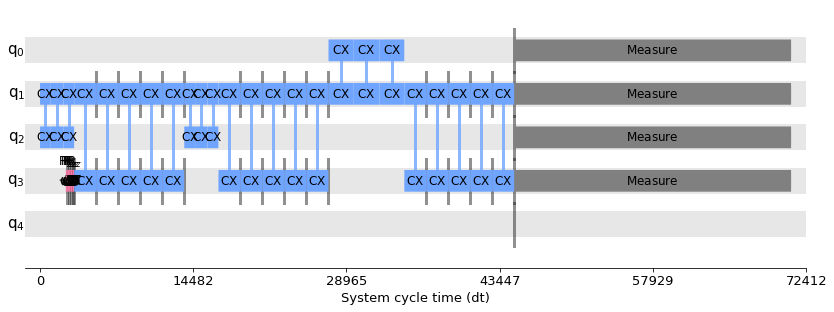

In [5]:
from qiskit import QuantumCircuit, transpile
from qiskit.test.mock import FakeVigo

# Simulator backend
target_backend = FakeVigo()
backend = DelayAerSimulator.from_backend(target_backend,
#                                          noise_model=None,
#                                          cross_talk_noise=False,
                                        )
properties = backend.properties()

#Make a cirucit
##opt1: simple GHZ state
# qc = QuantumCircuit(3)
# qc.h(0)
# qc.cx(0, 1)
# qc.cx(0, 2)
# qc.measure_all()
##opt2: complicated mess
# qc = QuantumCircuit(4)
# qc.h(0)
# qc.cx(0, 1)
# qc.x(1)
# qc.cx(0, 2)
# qc.x(2)
# qc.cz(1, 0)
# qc.h(1)
# qc.cx(1, 3)
# qc.measure_all()
qc = test_circuit(4, repeat=2)

# Schedule
sched_circ = transpile(qc, backend, scheduling_method='alap')
draw(sched_circ)

In [6]:
sched_circ.draw(fold=-1)

┌──────────────────┐                                                                                                                                                                                                                                                                                                                        ┌───┐     ┌──────────────────┐                                 ░                           ┌─┐   
      q_3 -> 0 ┤ DELAY(27264[dt]) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────────┤ X ├──■──┤ DELAY(10400[dt]) ├─────────────────────────────────░───────────────────────────┤M├───
               └──────────────────┘   ┌───┐                                                                                                                                                            ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░                    ┌───┐                         ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░        ┌─┴─┐       └─┬─┘┌─┴─┐└──────┬───┬───────┘ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░                           └╥┘┌─┐
      q_2 -> 1 ─────────■─────────────┤ X ├─────■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├─░─┤ X ├─░─┤ X ├─░─┤ X ├─░─┤ X ├─░──────────■─────────┤ X ├──■──────────────────────┤ X ├─░─┤ X ├─░─┤ X ├─░─┤ X ├─░─┤ X ├─░────────┤ X ├─────────■──┤ X ├───────┤ X ├─────────░─┤ X ├─░─┤ X ├─░─┤ X ├─░─┤ X ├─░────────────────────────────╫─┤M├
                      ┌─┴─┐           └─┬─┘   ┌─┴─┐ ┌──────────────────┐                                                                                                                               └─┬─┘ ░ └─┬─┘ ░ └─┬─┘ ░ └─┬─┘ ░ └─┬─┘ ░        ┌─┴─┐       └─┬─┘┌─┴─┐┌──────────────────┐└─┬─┘ ░ └─┬─┘ ░ └─┬─┘ ░ └─┬─┘ ░ └─┬─┘ ░        └───┘            └───┘       └─┬─┘         ░ └─┬─┘ ░ └─┬─┘ ░ └─┬─┘ ░ └─┬─┘ ░                        ┌─┐ ║ └╥┘
      q_1 -> 2 ───────┤ X ├─────────────■─────┤ X ├─┤ DELAY(10400[dt]) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────┼───────┼───────┼───────┼────────────┤ X ├─────────■──┤ X ├┤ DELAY(27968[dt]) ├──┼───────┼───────┼───────┼───────┼───────────────────────────────────────────┼───────────────┼───────┼───────┼───────┼───░────────────────────────┤M├─╫──╫─
               ┌──────┴───┴──────┐ ┌─────────┐├───┴┐└───┬─────────┬────┘ ░ ┌─────────┐┌────┐┌─────────┐ ░ ┌─────────┐┌────┐┌─────────┐ ░ ┌─────────┐┌────┐┌─────────┐ ░ ┌─────────┐┌────┐┌─────────┐ ░   │   ░   │   ░   │   ░   │   ░   │   ░ ┌──────┴───┴──────┐     └───┘└──────────────────┘  │   ░   │   ░   │   ░   │   ░   │   ░ ┌─────────────────┐                   │           ░   │   ░   │   ░   │   ░   │   ░                     ┌─┐└╥┘ ║  ║ 
      q_0 -> 3 ┤ DELAY(2432[dt]) ├─┤ RZ(π/2) ├┤ √X ├────┤ RZ(π/2) ├──────░─┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├─░─┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├─░─┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├─░─┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├─░───■───░───■───░───■───░───■───░───■───░─┤ DELAY(3232[dt]) ├────────────────────────────────■───░───■───░───■───░───■───░───■───░─┤ DELAY(7168[dt]) ├───────────────────■───────────░───■───░───■───░───■───░───■───░─────────────────────┤M├─╫──╫──╫─
               ├─────────────────┴┐└─────────┘└────┘    └─────────┘      ░ └─────────┘└────┘└─────────┘ ░ └─────────┘└────┘└─────────┘ ░ └─────────┘└────┘└─────────┘ ░ └─────────┘└────┘└─────────┘ ░       ░       ░       ░       ░       ░ └─────────────────┘                                    ░       ░       ░       ░       ░ └─────────────────┘                               ░       ░       ░       ░       ░ ┌──────────────────┐└╥┘ ║  ║  ║ 
ancilla_0 

Noise model:  NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'measure', 'sx', 'cx', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('sx', [0]), ('sx', [1]), ('sx', [2]), ('sx', [3]), ('sx', [4]), ('x', [0]), ('x', [1]), ('x', [2]), ('x', [3]), ('x', [4]), ('cx', [3, 4]), ('cx', [4, 3]), ('cx', [3, 1]), ('cx', [1, 3]), ('cx', [1, 2]), ('cx', [2, 1]), ('cx', [0, 1]), ('cx', [1, 0]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]


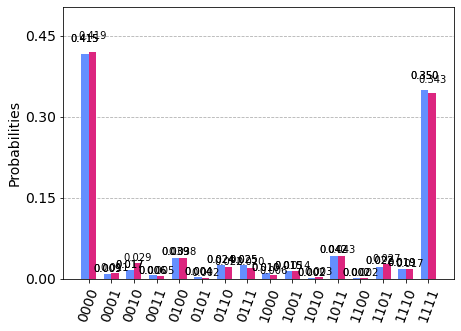

In [7]:
# Run using custom backend
shots = 10000
result_noise = backend.run([sched_circ], shots=shots).result()
##Note: if the circuit is sufficiently complicated, you should see a majority of correct counts
## plus a few scattered incorrect (error) counts
# result.get_counts(0)


from qiskit.visualization import plot_histogram

sim_ideal = FakeVigo()

result_ideal = sim_ideal.run([sched_circ], shots=shots).result()

counts_ideal = result_ideal.get_counts(0)
counts_noise = result_noise.get_counts(0)

plot_histogram([counts_ideal, counts_noise])

## Example 2a: Running the T1 Experiment with a normal backend

This requires installing the `qiskit-experiments` package from https://github.com/Qiskit/qiskit-experiments

The following code is based on the example usage of the T1 experiments at https://qiskit.org/documentation/experiments/tutorials/t1.html, but with my custom backend instead of a T1 example backend.

In [8]:
import numpy as np
from qiskit_experiments.library import T1

In [9]:
# Check backend recorded T1 of qubit-0 (this should be in 's' units)
t1_qubit0 = properties.t1(0)
t1_qubit0

0.00012170801410836628

Adding a job from a backend (qasm_simulator) that is different than the current backend (fake_vigo). The new backend will be used, but service is not changed if one already exists.
/Users/ethan/qiskitDev/officialVenv/lib/python3.8/site-packages/qiskit_experiments/curve_analysis/curve_fit.py:136: RuntimeWarning: invalid value encountered in sqrt
  popt_err = np.sqrt(np.diag(pcov))


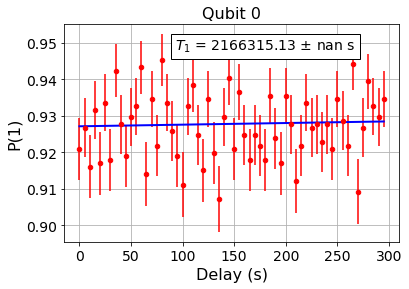

DbAnalysisResultV1
- name: T1
- value: 2166315.1291176463 ± nan s
- χ²: 1.3102986490272708
- quality: bad
- extra: <9 items>
- device_components: ['Q0']
- verified: False


In [10]:
delays = list(range(0, 300, 5))

# T1 Experiment on a typical backend
_t1exp = T1(qubit=0, delays=delays, unit='s')
_t1data = _t1exp.run(backend=FakeVigo(), shots=1000).block_for_results()

# Print analysis results
display(_t1data.figure(0))
_t1result = _t1data.analysis_results(-1)
print(_t1result)

## Example 2.b: Running a T1 experiment

In [12]:
# T1 experiment on qubit 0
t1exp = T1(qubit=0, delays=delays, unit='us')

# Run on the delay-noise backend
t1data = t1exp.run(backend=backend, shots=1000).block_for_results()

# Print analysis results
#   NOTE: if delay noise is correct this should show a plot of exponential decay
#   and fit a value close to the `t1_qubit0` target
display(t1data.figure(0))
t1result = t1data.analysis_results(-1)
print(t1result)

Noise model:  NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'measure', 'sx', 'cx', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('sx', [0]), ('sx', [1]), ('sx', [2]), ('sx', [3]), ('sx', [4]), ('x', [0]), ('x', [1]), ('x', [2]), ('x', [3]), ('x', [4]), ('cx', [3, 4]), ('cx', [4, 3]), ('cx', [3, 1]), ('cx', [1, 3]), ('cx', [1, 2]), ('cx', [2, 1]), ('cx', [0, 1]), ('cx', [1, 0]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]


Post processing function failed:
Traceback (most recent call last):
  File "/Users/ethan/qiskitDev/officialVenv/lib/python3.8/site-packages/qiskit_experiments/database_service/db_experiment_data.py", line 299, in _wait_for_job
    job_done_callback(self, **kwargs)
  File "/Users/ethan/qiskitDev/officialVenv/lib/python3.8/site-packages/qiskit_experiments/framework/base_experiment.py", line 192, in run_analysis
    analysis.run(experiment_data, **analysis_options)
  File "/Users/ethan/qiskitDev/officialVenv/lib/python3.8/site-packages/qiskit_experiments/framework/base_analysis.py", line 89, in run
    results, figures = self._run_analysis(experiment_data, **analysis_options)
  File "/Users/ethan/qiskitDev/officialVenv/lib/python3.8/site-packages/qiskit_experiments/library/characterization/t1_analysis.py", line 89, in _run_analysis
    unit = data[0]["metadata"]["unit"]
TypeError: 'NoneType' object is not subscriptable



IndexError: list index out of range

In [ ]:
t1_qubit0

In [ ]:
RZZGate(0.1).decompositions[0].draw()